In [3]:
#Data Manipulation libraries
import pandas as pd 
import numpy as np
import copy

In [4]:
#Preprocessing - Evaluation metrics
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [23]:
#Tensorflow/Keras library - Deep Learning models
import tensorflow
from keras.layers import SimpleRNN, LSTM, Conv1D, MaxPooling1D, Flatten, Concatenate, Dense
from keras.optimizers import Adam, RMSprop
from keras.callbacks import LearningRateScheduler
from keras import Input, Model, Sequential
import matplotlib.pyplot as plt

In [6]:
#Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [7]:
#Setting seed libraries
import os
import random
from tensorflow.random import set_seed
from keras.utils import set_random_seed
from keras import backend as K

In [8]:
# Setting seed value to 42
seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tensorflow.random.set_seed(seed_value)
session_conf = tensorflow.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tensorflow.compat.v1.Session(graph=tensorflow.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [9]:
#Importing data
data = pd.read_excel('default of credit card clients.xls',header=1)
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [10]:
'''
Function for initial preprocessing of the data:
1) replace EDUCATION values 0, 5, 6 with 4 ('other' category) since they are not mentioned in the data description
2) replace MARRIAGE value 0 with 3 ('other' category) as there is not a 0 category for marriage column on data description 
3) drop 'ID' column - useless
4) rename target column to DEFAULT, rename PAY_0 to PAY_1 for consistency and more accurate variable names
'''
def initial_preprocessing(df):
    print('EDUCATION values before preprocessing:\n',df['EDUCATION'].value_counts())
    df['EDUCATION'].replace([0,5,6],4,inplace=True)
    print()
    print('EDUCATION values after preprocessing:\n',df['EDUCATION'].value_counts())
    print()
    print('MARRIAGE values before preprocessing:\n',df['MARRIAGE'].value_counts())
    df['MARRIAGE'].replace(0,3,inplace=True)
    print()
    print('MARRIAGE values after preprocessing:\n',df['MARRIAGE'].value_counts())
    df.drop(columns='ID',inplace=True)
    df.rename(columns={"default payment next month": "DEFAULT","PAY_0": "PAY_1"},inplace=True)
    
    return df

In [11]:
#perform initial preprocessing
data = initial_preprocessing(data)

EDUCATION values before preprocessing:
 2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

EDUCATION values after preprocessing:
 2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

MARRIAGE values before preprocessing:
 2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

MARRIAGE values after preprocessing:
 2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64


In [12]:
'''
- train test split (20% test) before scaling and encoding to prevent data leakages 
- train set will be used for cross-validation/hyperparameter tuning and test set for final evaluation 
- Stratify is used to ensure that the proportion of the class labels will remain consistent
'''
X_train, X_test, y_train, y_test = train_test_split(data.drop('DEFAULT',axis=1),data['DEFAULT'],
                                                    test_size=0.2,stratify=data['DEFAULT'],random_state=42)
print('X_train shape:',X_train.shape)
print('X_test shape:',X_test.shape)

X_train shape: (24000, 23)
X_test shape: (6000, 23)


In [13]:
#Column transformer for Robust Scaler and One Hot Encoder 
## making sure to return the preprocessed dataframes for better inspection

class PreprocessorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns,columns_num, drop='first', handle_unknown='ignore',sparse_output=False):
        self.columns = columns
        self.columns_num = columns_num
        self.drop = drop
        self.handle_unknown = handle_unknown
        self.sparse_output = sparse_output
        self.encoders = {}
        self.robust_enc = {}

    def fit(self, X, y=None):
        for col in self.columns:
            encoder = OneHotEncoder(drop=self.drop, sparse_output=self.sparse_output, 
                                    handle_unknown=self.handle_unknown)
            encoder.fit(X[[col]])
            self.encoders[col] = encoder
        
        for col_num in self.columns_num:
            encoder_robust = RobustScaler()
            encoder_robust.fit(X[[col_num]])
            self.robust_enc[col_num] = encoder_robust
            
        return self

    def transform(self, X):
        transformed = X.copy()
        for col in self.columns:
            encoder = self.encoders[col]
            encoded_cols = encoder.transform(transformed[[col]])
            new_cols = [f"{col}_{value}" for value in encoder.categories_[0][1:]]
            encoded_cols_df = pd.DataFrame(encoded_cols, columns=new_cols, index=transformed.index)
            transformed = pd.concat([transformed, encoded_cols_df], axis=1)
        transformed = transformed.drop(self.columns, axis=1)
        
        for col_num in self.columns_num:
            encoder_robust = self.robust_enc[col_num]
            transformed[col_num] = encoder_robust.transform(transformed[[col_num]])
            
        return transformed

In [14]:
def preprocess_data(X_train, y_train, X_test, y_test):
    
    cat_cols = ['EDUCATION','MARRIAGE']
    numerical_cols = ['LIMIT_BAL', 'AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5',
                  'BILL_AMT6','PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    
    temp_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
    'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
    'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
    'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    
    PAY_cols = ['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2','PAY_1']
    BILL_AMT_cols = ['BILL_AMT6','BILL_AMT5','BILL_AMT4','BILL_AMT3','BILL_AMT2','BILL_AMT1']
    PAY_AMT_cols = ['PAY_AMT6','PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1']
    
    #fitting the column transformer
    enc = PreprocessorTransformer(columns = cat_cols, columns_num= numerical_cols,
                                  drop='first',handle_unknown='ignore',sparse_output=False) 
    
    X_train_preprocessed = enc.fit_transform(X_train)
    X_test_preprocessed = enc.transform(X_test)
    
    static_cols_train = X_train_preprocessed.drop(temp_cols,axis=1).columns.to_list()
    static_cols_test = X_test_preprocessed.drop(temp_cols,axis=1).columns.to_list()
    
    #separation of static and temporal features
    X_train_temp = X_train_preprocessed[temp_cols]
    X_train_static = X_train_preprocessed[static_cols_train]
    X_test_temp = X_test_preprocessed[temp_cols]
    X_test_static = X_test_preprocessed[static_cols_test]

    PAY_train = X_train_temp[PAY_cols].to_numpy()
    BILL_AMT_train = X_train_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_train = X_train_temp[PAY_AMT_cols].to_numpy()
    
    PAY_test = X_test_temp[PAY_cols].to_numpy()
    BILL_AMT_test = X_test_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_test = X_test_temp[PAY_AMT_cols].to_numpy()   
    
    # Stacking temporal features
    stacked_train = np.dstack((PAY_train, BILL_AMT_train, PAY_AMT_train))
    stacked_test = np.dstack((PAY_test, BILL_AMT_test, PAY_AMT_test))
    y_train_preprocessed = y_train.to_numpy()
    y_test_preprocessed = y_test.to_numpy()
    
    return stacked_train, X_train_static, y_train_preprocessed, stacked_test, X_test_static, y_test_preprocessed
    

In [16]:
X_train_temporal, X_train_static, y_train_preprocessed, X_test_temporal,\
X_test_static, y_test_preprocessed = preprocess_data(X_train, y_train, X_test, y_test)

In [17]:
num_time_steps, num_features = X_train_temporal.shape[1], X_train_temporal.shape[2]

## Temporal Features

In [18]:
# Optimized temporal models (Dense layer)

def RNN_Temporal():
    model = Sequential()
    model.add(SimpleRNN(32,return_sequences=True, input_shape=(num_time_steps, num_features)))
    model.add(SimpleRNN(32,return_sequences = True))
    model.add(SimpleRNN(32,return_sequences = True))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

def LSTM_Temporal():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(num_time_steps, num_features)))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

def CNN_Temporal():
    model = Sequential()
    model.add(Conv1D(filters=4, kernel_size=5, padding='same', activation='relu',
                     input_shape=(num_time_steps, num_features)))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Conv1D(filters=8, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [19]:
# Optimized temporal models (with ML in FCL)

def RNN_Temporal_LR():
    model = Sequential()
    model.add(SimpleRNN(32, return_sequences=True, input_shape=(num_time_steps, num_features)))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(Flatten(name='FLATTEN'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def LSTM_Temporal_LR():
    model = Sequential()
    model.add(LSTM(16, return_sequences=True, input_shape=(num_time_steps, num_features)))
    model.add(Flatten(name='FLATTEN'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def CNN_Temporal_LR():
    model = Sequential()
    model.add(Conv1D(filters=4, kernel_size=5, padding='same', activation='relu', 
                     input_shape=(num_time_steps, num_features)))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Conv1D(filters=8, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten(name='FLATTEN'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def RNN_Temporal_RF():
    model = Sequential()
    model.add(SimpleRNN(32, return_sequences=True, input_shape=(num_time_steps, num_features)))
    model.add(Flatten(name='FLATTEN'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def LSTM_Temporal_RF():
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(num_time_steps, num_features)))
    model.add(Flatten(name='FLATTEN'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def CNN_Temporal_RF():
    model = Sequential()
    model.add(Conv1D(filters=8, kernel_size=5, padding='same', activation='relu',
                     input_shape=(num_time_steps, num_features)))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten(name='FLATTEN'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def RNN_Temporal_XGB():
    model = Sequential()
    model.add(SimpleRNN(16, return_sequences=True, input_shape=(num_time_steps, num_features)))
    model.add(Flatten(name='FLATTEN'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def LSTM_Temporal_XGB():
    model = Sequential()
    model.add(LSTM(16, return_sequences=True, input_shape=(num_time_steps, num_features)))
    model.add(Flatten(name='FLATTEN'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def CNN_Temporal_XGB():
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=5, padding='same', activation='relu', 
                     input_shape=(num_time_steps, num_features)))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten(name='FLATTEN'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [20]:
# Function for training and evaluating on test set for optimized configurations (temporal - dense)

def temporal_dense_evaluation(X_train, y_train, X_test, y_test, batch_size, optimizer, 
                              initial_learning_rate, model):
    
    decay_rate = 0.1  # Decay rate
    decay_steps = 20  # Decay steps (number of steps before applying decay)
    epochs = 50

    def learning_rate_scheduler(epoch):
        return initial_learning_rate * decay_rate ** (epoch // decay_steps)
    
    if optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=initial_learning_rate)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate=initial_learning_rate)
    
    # Build and compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test, y_test), shuffle=False, callbacks=[lr_scheduler])

    # Plot the loss on train vs validate tests
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Evaluate on the testing set
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs >= 0.5).astype(int)

    test_accuracy =  accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_f1 =  f1_score(y_test, y_pred)
    
    # Evaluate on the training set
    y_train_pred_probs = model.predict(X_train)
    y_train_pred = (y_train_pred_probs >= 0.5).astype(int)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
   
    print(f"Testing Set Performance")
    print("Accuracy: %.3f" % test_accuracy)
    print("Precision: %.3f" % test_precision)
    print("Recall: %.3f" % test_recall)
    print("F1 score: %.3f" % test_f1)
  
    print('-----------------------------------')
    print(f"Training Set Performance")
    print("Accuracy: %.3f" % train_accuracy)
    print("Precision: %.3f" % train_precision)
    print("Recall: %.3f" % train_recall)
    print("F1 score: %.3f" % train_f1)
   

In [21]:
# Function for training and evaluating on test set for optimized configurations (temporal - ML)

def temporal_ML_evaluation(X_train, y_train, X_test, y_test, batch_size, optimizer, 
                           initial_learning_rate, model, ml_model):
    
    decay_rate = 0.1  # Decay rate
    decay_steps = 20  # Decay steps (number of steps before applying decay)
    epochs = 50

    def learning_rate_scheduler(epoch):
        return initial_learning_rate * decay_rate ** (epoch // decay_steps)
    
    if optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=initial_learning_rate)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate=initial_learning_rate)
    
    # Build and compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_test, y_test), shuffle=False, callbacks=[lr_scheduler])

    # Plot the loss on train vs validate tests
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    preds,preds_train = classifier_prediction_temporal(X_train,X_test, y_train, 
                                                       model = ml_model, feature_extractor_model= model, 
                                                       layer_name='FLATTEN')
    
    
    # Evaluate on the testing set
    test_accuracy = accuracy_score(y_test, preds)
    test_precision = precision_score(y_test, preds)
    test_recall = recall_score(y_test, preds)
    test_f1 = f1_score(y_test, preds)
    
    # Evaluate on the training set
    train_accuracy = accuracy_score(y_train, preds_train)
    train_precision = precision_score(y_train, preds_train)
    train_recall = recall_score(y_train, preds_train)
    train_f1 = f1_score(y_train, preds_train)
   
    print(f"Testing Set Performance")
    print("Accuracy: %.3f" % test_accuracy)
    print("Precision: %.3f" % test_precision)
    print("Recall: %.3f" % test_recall)
    print("F1 score: %.3f" % test_f1)
  
    print('-----------------------------------')
    print(f"Training Set Performance")
    print("Accuracy: %.3f" % train_accuracy)
    print("Precision: %.3f" % train_precision)
    print("Recall: %.3f" % train_recall)
    print("F1 score: %.3f" % train_f1)
   

### RNN Temporal (Dense)

Epoch 1/50
750/750 [==============================] - 5s 5ms/step - loss: 0.4906 - accuracy: 0.7809 - val_loss: 0.4631 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 2/50
750/750 [==============================] - 4s 5ms/step - loss: 0.4547 - accuracy: 0.8040 - val_loss: 0.4538 - val_accuracy: 0.8037 - lr: 1.0000e-04
Epoch 3/50
750/750 [==============================] - 4s 6ms/step - loss: 0.4479 - accuracy: 0.8074 - val_loss: 0.4497 - val_accuracy: 0.8068 - lr: 1.0000e-04
Epoch 4/50
750/750 [==============================] - 4s 5ms/step - loss: 0.4443 - accuracy: 0.8095 - val_loss: 0.4474 - val_accuracy: 0.8082 - lr: 1.0000e-04
Epoch 5/50
750/750 [==============================] - 4s 5ms/step - loss: 0.4419 - accuracy: 0.8117 - val_loss: 0.4457 - val_accuracy: 0.8083 - lr: 1.0000e-04
Epoch 6/50
750/750 [==============================] - 4s 5ms/step - loss: 0.4401 - accuracy: 0.8129 - val_loss: 0.4444 - val_accuracy: 0.8108 - lr: 1.0000e-04
Epoch 7/50
750/750 [==========================

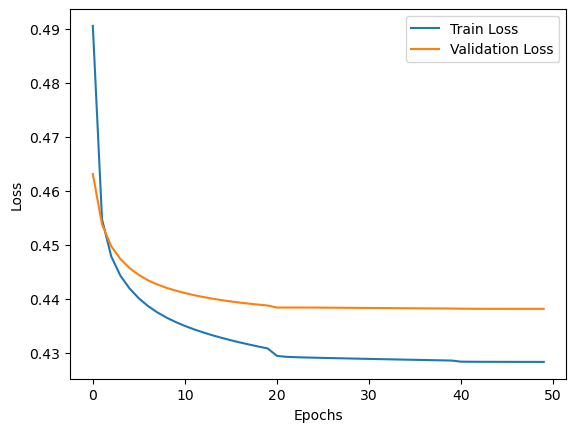

750/750 [==============================] - 3s 4ms/step
Testing Set Performance
Accuracy: 0.816
Precision: 0.653
Recall: 0.359
F1 score: 0.464
-----------------------------------
Training Set Performance
Accuracy: 0.822
Precision: 0.675
Recall: 0.377
F1 score: 0.484


In [24]:
temporal_dense_evaluation(X_train_temporal, y_train_preprocessed,X_test_temporal, y_test_preprocessed,batch_size=32,
                          optimizer='rmsprop',initial_learning_rate=0.0001, model=RNN_Temporal())

### LSTM Temporal (Dense)

In [ ]:
temporal_dense_evaluation(X_train_temporal, y_train_preprocessed,X_test_temporal, y_test_preprocessed,batch_size=64,
                          optimizer='adam',initial_learning_rate=0.0001, model=LSTM_Temporal())

### CNN Temporal (Dense)

In [ ]:
temporal_dense_evaluation(X_train_temporal, y_train_preprocessed,X_test_temporal, y_test_preprocessed,batch_size=64,
                          optimizer='adam',initial_learning_rate=0.001, model=CNN_Temporal())

### RNN Temporal + ML Models

In [ ]:
temporal_ML_evaluation(X_train_temporal, y_train_preprocessed,X_test_temporal, y_test_preprocessed,batch_size=128,
                       optimizer='rmsprop',initial_learning_rate=0.0001, 
                       model=RNN_Temporal_LR(),ml_model = LogisticRegression())

In [ ]:
temporal_ML_evaluation(X_train_temporal, y_train_preprocessed,X_test_temporal, y_test_preprocessed,batch_size=64,
                       optimizer='adam',initial_learning_rate=0.001, 
                       model=RNN_Temporal_RF(),ml_model = RandomForestClassifier())

In [ ]:
temporal_ML_evaluation(X_train_temporal, y_train_preprocessed,X_test_temporal, y_test_preprocessed,batch_size=64,
                       optimizer='adam',initial_learning_rate=0.0001, 
                       model=RNN_Temporal_XGB(),ml_model = XGBClassifier())

### LSTM Temporal + ML Models

In [ ]:
temporal_ML_evaluation(X_train_temporal, y_train_preprocessed,X_test_temporal, y_test_preprocessed,batch_size=32,
                       optimizer='adam',initial_learning_rate=0.0001, 
                       model=LSTM_Temporal_LR(),ml_model = LogisticRegression())

In [ ]:
temporal_ML_evaluation(X_train_temporal, y_train_preprocessed,X_test_temporal, y_test_preprocessed,batch_size=64,
                       optimizer='rmsprop',initial_learning_rate=0.001,
                       model=LSTM_Temporal_RF(),ml_model = RandomForestClassifier())

In [ ]:
temporal_ML_evaluation(X_train_temporal, y_train_preprocessed,X_test_temporal, y_test_preprocessed,batch_size=32,
                       optimizer='rmsprop',initial_learning_rate=0.0001, 
                       model=LSTM_Temporal_XGB(),ml_model = XGBClassifier())

### CNN Temporal + ML Models

In [ ]:
temporal_ML_evaluation(X_train_temporal, y_train_preprocessed,X_test_temporal, y_test_preprocessed,batch_size=64,
                       optimizer='adam',initial_learning_rate=0.001, 
                       model=CNN_Temporal_LR(),ml_model = LogisticRegression())

In [ ]:
temporal_ML_evaluation(X_train_temporal, y_train_preprocessed,X_test_temporal, y_test_preprocessed,batch_size=64,
                       optimizer='adam',initial_learning_rate=0.001, 
                       model=CNN_Temporal_RF(),ml_model = RandomForestClassifier())

In [ ]:
temporal_ML_evaluation(X_train_temporal, y_train_preprocessed,X_test_temporal, y_test_preprocessed,batch_size=64,
                       optimizer='adam',initial_learning_rate=0.001, 
                       model=CNN_Temporal_XGB(),ml_model = XGBClassifier())

## Static + Temporal Features

In [25]:
# Optimized Concat models (Dense layer)

def RNN_Concat():
    rnn_layer = SimpleRNN(64,return_sequences=True, name = 'RNN_LAYER_1')(temporal_input)
    rnn_layer = SimpleRNN(64,return_sequences=True, name = 'RNN_LAYER_2')(rnn_layer)
    rnn_layer = SimpleRNN(64,return_sequences=True, name = 'RNN_LAYER_3')(rnn_layer)
    rnn_layer = Flatten(name = 'FLATTEN')(rnn_layer)
    RNN_combined = Concatenate(axis=1, name ='RNN_CONCAT')([rnn_layer,static_input])
    output = Dense(1,activation='sigmoid',name='RNN_OUTPUT_LAYER')(RNN_combined)
    model = Model(inputs=[temporal_input,static_input],outputs=[output])
    return model

def LSTM_Concat():
    lstm_layer = LSTM(64,return_sequences=True, name = 'LSTM_LAYER_1')(temporal_input)
    lstm_layer = LSTM(64,return_sequences=True, name = 'LSTM_LAYER_2')(lstm_layer)
    lstm_layer = LSTM(64,return_sequences=True, name = 'LSTM_LAYER_3')(lstm_layer)
    lstm_layer = LSTM(64,return_sequences=True, name = 'LSTM_LAYER_4')(lstm_layer)
    lstm_layer = Flatten(name = 'FLATTEN')(lstm_layer)
    LSTM_combined = Concatenate(axis=1, name ='LSTM_CONCAT')([lstm_layer,static_input])
    output = Dense(1,activation='sigmoid',name='LSTM_OUTPUT_LAYER')(LSTM_combined)
    model = Model(inputs=[temporal_input,static_input],outputs=[output])
    return model

def CNN_Concat():
    cnn_layer = Conv1D(filters=256, kernel_size=5, activation='relu',padding='same', name=f'CNN_LAYER_1')(temporal_input)
    cnn_layer = MaxPooling1D(pool_size=3)(cnn_layer)
    cnn_layer = Flatten(name='FLATTEN')(cnn_layer)
    CNN_combined = Concatenate(axis=1, name='cnn_CONCAT')([cnn_layer, static_input])
    output = Dense(1, activation='sigmoid', name='cnn_OUTPUT_LAYER')(CNN_combined)
    model = Model(inputs=[temporal_input, static_input], outputs=[output])
    return model

In [26]:
# Optimized Concat models (with ML in FCL)

def RNN_Concat_LR():
    rnn_layer = SimpleRNN(32,return_sequences=True, name = 'RNN_LAYER_1')(temporal_input)
    rnn_layer = SimpleRNN(32,return_sequences=True, name = 'RNN_LAYER_2')(rnn_layer)
    rnn_layer = Flatten(name = 'FLATTEN')(rnn_layer)
    RNN_combined = Concatenate(axis=1, name ='CONCAT')([rnn_layer,static_input])
    output = Dense(1,activation='sigmoid',name='RNN_OUTPUT_LAYER')(RNN_combined)
    model = Model(inputs=[temporal_input,static_input],outputs=[output])
    return model

def LSTM_Concat_LR():
    lstm_layer = LSTM(32,return_sequences=True, name = 'LSTM_LAYER_1')(temporal_input)
    lstm_layer = LSTM(32,return_sequences=True, name = 'LSTM_LAYER_2')(lstm_layer)
    lstm_layer = Flatten(name = 'FLATTEN')(lstm_layer)
    LSTM_combined = Concatenate(axis=1, name ='CONCAT')([lstm_layer,static_input])
    output = Dense(1,activation='sigmoid',name='LSTM_OUTPUT_LAYER')(LSTM_combined)
    model = Model(inputs=[temporal_input,static_input],outputs=[output])
    return model

def CNN_Concat_LR():
    cnn_layer = Conv1D(filters=4, kernel_size=5, activation='relu',padding='same', name=f'CNN_LAYER_1')(temporal_input)
    cnn_layer = MaxPooling1D(pool_size=3)(cnn_layer)
    cnn_layer = Conv1D(filters=8, kernel_size=3, activation='relu',padding='same', name=f'CNN_LAYER_2')(cnn_layer)
    cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
    cnn_layer = Flatten(name='FLATTEN')(cnn_layer)
    CNN_combined = Concatenate(axis=1, name='CONCAT')([cnn_layer, static_input])
    output = Dense(1, activation='sigmoid', name='cnn_OUTPUT_LAYER')(CNN_combined)
    model = Model(inputs=[temporal_input, static_input], outputs=[output])
    return model

def RNN_Concat_RF():
    rnn_layer = SimpleRNN(16,return_sequences=True, name = 'RNN_LAYER_1')(temporal_input)
    rnn_layer = Flatten(name = 'FLATTEN')(rnn_layer)
    RNN_combined = Concatenate(axis=1, name ='CONCAT')([rnn_layer,static_input])
    output = Dense(1,activation='sigmoid',name='RNN_OUTPUT_LAYER')(RNN_combined)
    model = Model(inputs=[temporal_input,static_input],outputs=[output])
    return model

def LSTM_Concat_RF():
    lstm_layer = LSTM(16,return_sequences=True, name = 'LSTM_LAYER_1')(temporal_input)
    lstm_layer = Flatten(name = 'FLATTEN')(lstm_layer)
    LSTM_combined = Concatenate(axis=1, name ='CONCAT')([lstm_layer,static_input])
    output = Dense(1,activation='sigmoid',name='LSTM_OUTPUT_LAYER')(LSTM_combined)
    model = Model(inputs=[temporal_input,static_input],outputs=[output])
    return model

def CNN_Concat_RF():
    cnn_layer = Conv1D(filters=8, kernel_size=5, activation='relu',padding='same', name=f'CNN_LAYER_1')(temporal_input)
    cnn_layer = MaxPooling1D(pool_size=3)(cnn_layer)
    cnn_layer = Conv1D(filters=16, kernel_size=3, activation='relu',padding='same', name=f'CNN_LAYER_2')(cnn_layer)
    cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
    cnn_layer = Flatten(name='FLATTEN')(cnn_layer)
    CNN_combined = Concatenate(axis=1, name='CONCAT')([cnn_layer, static_input])
    output = Dense(1, activation='sigmoid', name='cnn_OUTPUT_LAYER')(CNN_combined)
    model = Model(inputs=[temporal_input, static_input], outputs=[output])
    return model

def RNN_Concat_XGB():
    rnn_layer = SimpleRNN(128,return_sequences=True, name = 'RNN_LAYER_1')(temporal_input)
    rnn_layer = SimpleRNN(128,return_sequences=True, name = 'RNN_LAYER_2')(rnn_layer)
    rnn_layer = Flatten(name = 'FLATTEN')(rnn_layer)
    RNN_combined = Concatenate(axis=1, name ='CONCAT')([rnn_layer,static_input])
    output = Dense(1,activation='sigmoid',name='RNN_OUTPUT_LAYER')(RNN_combined)
    model = Model(inputs=[temporal_input,static_input],outputs=[output])
    return model

def LSTM_Concat_XGB():
    lstm_layer = LSTM(32,return_sequences=True, name = 'LSTM_LAYER_1')(temporal_input)
    lstm_layer = LSTM(32,return_sequences=True, name = 'LSTM_LAYER_2')(lstm_layer)
    lstm_layer = LSTM(32,return_sequences=True, name = 'LSTM_LAYER_3')(lstm_layer)
    lstm_layer = Flatten(name = 'FLATTEN')(lstm_layer)
    LSTM_combined = Concatenate(axis=1, name ='CONCAT')([lstm_layer,static_input])
    output = Dense(1,activation='sigmoid',name='LSTM_OUTPUT_LAYER')(LSTM_combined)
    model = Model(inputs=[temporal_input,static_input],outputs=[output])
    return model

def CNN_Concat_XGB():
    cnn_layer = Conv1D(filters=4, kernel_size=5, activation='relu',padding='same', name=f'CNN_LAYER_1')(temporal_input)
    cnn_layer = MaxPooling1D(pool_size=3)(cnn_layer)
    cnn_layer = Conv1D(filters=8, kernel_size=3, activation='relu',padding='same', name=f'CNN_LAYER_2')(cnn_layer)
    cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
    cnn_layer = Flatten(name='FLATTEN')(cnn_layer)
    CNN_combined = Concatenate(axis=1, name='CONCAT')([cnn_layer, static_input])
    output = Dense(1, activation='sigmoid', name='cnn_OUTPUT_LAYER')(CNN_combined)
    model = Model(inputs=[temporal_input, static_input], outputs=[output])
    return model

In [27]:
#Inputs
temporal_input = Input(shape=(num_time_steps, num_features),name = 'TEMPORAL_INPUT')
static_input = Input(shape=(X_train_static.shape[1]),name = 'STATIC_INPUT')

In [28]:
# Function for training and evaluating on test set for optimized configurations (concat - dense)

def concat_dense_evaluation(X_train_temporal,X_train_static, y_train, X_test_temporal,
                            X_test_static, y_test, batch_size, optimizer, initial_learning_rate, model):
    
    decay_rate = 0.1  # Decay rate
    decay_steps = 20  # Decay steps (number of steps before applying decay)
    epochs = 50

    def learning_rate_scheduler(epoch):
        return initial_learning_rate * decay_rate ** (epoch // decay_steps)
    
    if optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=initial_learning_rate)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate=initial_learning_rate)
    
    # Build and compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

    # Train the model
    history = model.fit([X_train_temporal, X_train_static], y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=([X_test_temporal, X_test_static], y_test),
                        shuffle=False,callbacks = [lr_scheduler])

    # Plot the loss on train vs validate tests
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Evaluate on the testing set
    y_pred_probs = model.predict([X_test_temporal, X_test_static])
    y_pred = (y_pred_probs >= 0.5).astype(int)

    test_accuracy =  accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_f1 =  f1_score(y_test, y_pred)
    
    # Evaluate on the training set
    y_train_pred_probs = model.predict([X_train_temporal, X_train_static])
    y_train_pred = (y_train_pred_probs >= 0.5).astype(int)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
   
    print(f"Testing Set Performance")
    print("Accuracy: %.3f" % test_accuracy)
    print("Precision: %.3f" % test_precision)
    print("Recall: %.3f" % test_recall)
    print("F1 score: %.3f" % test_f1)
  
    print('-----------------------------------')
    print(f"Training Set Performance")
    print("Accuracy: %.3f" % train_accuracy)
    print("Precision: %.3f" % train_precision)
    print("Recall: %.3f" % train_recall)
    print("F1 score: %.3f" % train_f1)
   

In [ ]:
# Function for training and evaluating on test set for optimized configurations (concat - ML)

def concat_ML_evaluation(X_train_temporal,X_train_static, y_train, X_test_temporal, 
                         X_test_static, y_test, batch_size, optimizer, initial_learning_rate, model, ml_model):
    
    decay_rate = 0.1  # Decay rate
    decay_steps = 20  # Decay steps (number of steps before applying decay)
    epochs = 50

    def learning_rate_scheduler(epoch):
        return initial_learning_rate * decay_rate ** (epoch // decay_steps)
    
    if optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=initial_learning_rate)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate=initial_learning_rate)
    
    # Build and compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

    # Train the model
    history = model.fit([X_train_temporal, X_train_static], y_train,
                                                            epochs=epochs, batch_size=batch_size,
                                                            validation_data=([X_test_temporal, X_test_static], y_test),
                                                            shuffle=False, callbacks=[lr_scheduler])

    # Plot the loss on train vs validate tests
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    preds,preds_train = classifier_prediction(X_train_temporal,X_test_temporal,X_train_static, 
                                              X_test_static,y_train,y_test, model = ml_model, 
                                              feature_extractor_model = model, layer_name='CONCAT')
    
    
    # Evaluate on the testing set
    test_accuracy = accuracy_score(y_test, preds)
    test_precision = precision_score(y_test, preds)
    test_recall = recall_score(y_test, preds)
    test_f1 =  f1_score(y_test, preds)
    
    # Evaluate on the training set
    train_accuracy = accuracy_score(y_train, preds_train)
    train_precision = precision_score(y_train, preds_train)
    train_recall = recall_score(y_train, preds_train)
    train_f1 = f1_score(y_train, preds_train)
   
    print(f"Testing Set Performance")
    print("Accuracy: %.3f" % test_accuracy)
    print("Precision: %.3f" % test_precision)
    print("Recall: %.3f" % test_recall)
    print("F1 score: %.3f" % test_f1)
  
    print('-----------------------------------')
    print(f"Training Set Performance")
    print("Accuracy: %.3f" % train_accuracy)
    print("Precision: %.3f" % train_precision)
    print("Recall: %.3f" % train_recall)
    print("F1 score: %.3f" % train_f1)

### RNN Concat (Dense)

In [ ]:
concat_dense_evaluation(X_train_temporal,X_train_static, y_train_preprocessed, X_test_temporal, X_test_static, 
                        y_test_preprocessed, batch_size=64, optimizer='adam',
                        initial_learning_rate=0.0001, model=RNN_Concat())

### LSTM Concat (Dense)

In [ ]:
concat_dense_evaluation(X_train_temporal,X_train_static, y_train_preprocessed, X_test_temporal, X_test_static,
                        y_test_preprocessed, batch_size=64, optimizer='adam', 
                        initial_learning_rate=0.0001, model=LSTM_Concat())

### CNN Concat (Dense)

In [ ]:
concat_dense_evaluation(X_train_temporal,X_train_static, y_train_preprocessed, X_test_temporal, X_test_static,
                        y_test_preprocessed, batch_size=64, optimizer='adam', 
                        initial_learning_rate=0.001, model=CNN_Concat())

### RNN Concat + ML Models

In [ ]:
concat_ML_evaluation(X_train_temporal,X_train_static, y_train_preprocessed, X_test_temporal, X_test_static,
                     y_test_preprocessed, batch_size=128, optimizer='adam',
                     initial_learning_rate=0.0001, model=RNN_Concat_LR(), ml_model=LogisticRegression())

In [ ]:
concat_ML_evaluation(X_train_temporal,X_train_static, y_train_preprocessed, X_test_temporal,
                     X_test_static, y_test_preprocessed, batch_size=32, optimizer='rmsprop', 
                     initial_learning_rate=0.0001, model=RNN_Concat_RF(), ml_model=RandomForestClassifier())

In [ ]:
concat_ML_evaluation(X_train_temporal,X_train_static, y_train_preprocessed, X_test_temporal,
                     X_test_static, y_test_preprocessed, batch_size=128, optimizer='adam',
                     initial_learning_rate=0.0001, model=RNN_Concat_XGB(), ml_model=XGBClassifier())

### LSTM Concat + ML Models

In [ ]:
concat_ML_evaluation(X_train_temporal,X_train_static, y_train_preprocessed, X_test_temporal, X_test_static,
                     y_test_preprocessed, batch_size=64, optimizer='adam', 
                     initial_learning_rate=0.0001, model=LSTM_Concat_LR(), ml_model=LogisticRegression())

In [ ]:
concat_ML_evaluation(X_train_temporal,X_train_static, y_train_preprocessed, X_test_temporal,
                     X_test_static, y_test_preprocessed, batch_size=64, optimizer='adam',
                     initial_learning_rate=0.001, model=LSTM_Concat_RF(), ml_model=RandomForestClassifier())

In [ ]:
concat_ML_evaluation(X_train_temporal,X_train_static, y_train_preprocessed, X_test_temporal,
                     X_test_static, y_test_preprocessed, batch_size=64, optimizer='adam',
                     initial_learning_rate=0.0001, model=LSTM_Concat_XGB(), ml_model=XGBClassifier())

### CNN Concat + ML Models

In [ ]:
concat_ML_evaluation(X_train_temporal,X_train_static, y_train_preprocessed, X_test_temporal, X_test_static,
                     y_test_preprocessed, batch_size=32, optimizer='adam', 
                     initial_learning_rate=0.001, model=CNN_Concat_LR(), ml_model=LogisticRegression())

In [ ]:
concat_ML_evaluation(X_train_temporal,X_train_static, y_train_preprocessed, X_test_temporal, X_test_static,
                     y_test_preprocessed, batch_size=64, optimizer='adam', 
                     initial_learning_rate=0.001, model=CNN_Concat_RF(), ml_model=RandomForestClassifier())

In [ ]:
concat_ML_evaluation(X_train_temporal,X_train_static, y_train_preprocessed, X_test_temporal, X_test_static,
                     y_test_preprocessed, batch_size=64, optimizer='adam', 
                     initial_learning_rate=0.001, model=CNN_Concat_XGB(), ml_model=XGBClassifier())